# TSP Approximation
### Idea
The following sheet compares both the runtime and approximation ration of a native optimal TSP solver with a fast  2-approximation 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree


In [216]:
class City():
    def __init__(self, coordinates):
        self.position = coordinates
    
    def get_distance_to(self, other_city):
        my_x, my_y = self.position
        other_x, other_y = other_city.get_position()
        return ( (my_x-other_x)**2 + (my_y-other_y)**2 )**0.5 
        
    def get_position(self):
        return self.position

class CityBoard():
    def __init__(self, corner = (0,0), width = 10.0, height = 5.0):
        self.corner = corner  #top-left vetex
        self.width = width
        self.height = height
    
    def generateCities(self, amount, generate_adjacency_matrix=True):
        self.count_citys = amount
        self.minimum_spanning_tree = None
        self.adjacency_matrix = None
        
        cities = []
        while(len(cities) < amount):
            x = np.random.uniform(self.corner[0], self.corner[0]+self.width )
            y = np.random.uniform(self.corner[1], self.corner[1]+self.height)
            if (x,y) not in cities:
                cities.append( (x,y) )
        self.cities = [City(coordinates) for coordinates in  cities]
        if generate_adjacency_matrix:
            self.generate_adjacency_matrix()
    
    def get_board_plot(self):
        cities = self.cities
        n = len(cities)
        x = [city.get_position()[0] for city in cities]
        y = [city.get_position()[1] for city in cities]
                
        fig, ax = plt.subplots()
        
        plt.axis('scaled')
        plt.ylim(self.corner[1], self.corner[1]+self.height)
        plt.xlim(self.corner[0], self.corner[0]+self.width)
        
        ax.plot(x, y, 'o', color='blue')
        
        for i in range(n):
            ax.annotate(i, (x[i], y[i]))
    
    def plot_solutions(self, solutions):
        
        if solutions == None:return 
        
        for (route, cost, pathtype) in solutions:
        
            cities = self.cities
            positions = [cities[i].position for i in route]
            positions.append(positions[0])
            x = [position[0] for position in positions]
            y = [position[1] for position in positions]

            plt.plot(x,y, label=pathtype) 
        plt.legend()
    
    
    def get_minimum_spanning_tree(self):
        if self.minimum_spanning_tree == None:
            self.generate_minimum_spanning_tree()
        return self.minimum_spanning_tree
    
    def generate_minimum_spanning_tree(self):
        n = self.count_citys
        cities = self.cities
        adjacency_matrix = self.adjacency_matrix
        mst_sparse_matrix = minimum_spanning_tree(adjacency_matrix)
        rows,columns = mst_sparse_matrix.nonzero()
        self.minimum_spanning_tree = zip(rows, columns)
    
    def generate_adjacency_matrix(self):
        n = self.count_citys
        cities = self.cities
        
        matrix = np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                cost = cities[i].get_distance_to(cities[j])
                matrix[i,j] = cost
                matrix[j,i] = cost
                
        self.adjacency_matrix = matrix
    
    def plot(self, results=None):
        self.get_board_plot()
        self.plot_solutions(results)
        plt.show()
        

class DepthFirstSearcher:
    def __init__(self, graph):
        self.graph = graph
        self.traversal = []
        self.children = dict()
        
        for s,t in graph:
            self.children[s] = (self.children[s] | {t} ) if s in self.children else {t}
            self.children[t] = (self.children[t] | {s} ) if t in self.children else {s}
         
    def traverse(self, node):
        if node == None:
            return
        self.traversal.append(node)
        for child in self.children[node]:
            if child not in self.traversal:
                self.traverse(child)
                self.traversal.append(node)
        return self.traversal
          
    def get_traversal_without_repetitoins(self):
        unique_traversal = []
        for node in self.traversal:
            unique_traversal.append(node) if node not in unique_traversal else None
        return unique_traversal
                

class RouteUtil:
    @staticmethod 
    def get_route_cost(route, city_board):
        route_cost = 0
        n = len(route)
        for i in range(n):
            route_cost += city_board.adjacency_matrix[route[i], route[(i+1) % n]]
        return route_cost
        
        
class RandomSolver:
    @staticmethod
    def solve(city_board):
        start_time = time.time()
        #'calculate' random route
        random_route = np.random.permutation(list(range(city_board.count_citys)))
        
        #determine cost
        random_route_cost =  RouteUtil.get_route_cost(random_route, city_board)
        end_time = time.time()
        return (random_route, random_route_cost, end_time - start_time)
        
        
class MSTSolver:
    @staticmethod
    def solve(city_board):
        start_time = time.time()
        mst = city_board.get_minimum_spanning_tree()
        twoapprox_edges =  []
               
        #depth first search:
        startnode = mst[0][0]
        searcher = DepthFirstSearcher(mst)
        whole_mst_traversal = searcher.traverse(startnode)
        best_route = searcher.get_traversal_without_repetitoins()
        
        #determine cost
        best_route_cost = RouteUtil.get_route_cost(best_route, city_board)
        
        end_time = time.time()
        return (best_route, best_route_cost, end_time - start_time)
        
class OptimalSolver:
    @staticmethod
    def solve(city_board):
        #iterate through all combinatins and use best found solution
        
        start_time = time.time()
        n = city_board.count_citys
        adjacency_matrix = city_board.adjacency_matrix
        
        permutations = itertools.permutations( list(range(n)) )
        best_route = []
        best_route_cost = float('inf')
        
        for route in permutations:
            cost = 0 
            for i in range(n):
                cost += adjacency_matrix[route[i], route[(i+1) % n]]
            
            if cost < best_route_cost:
                best_route_cost =  cost
                best_route = route
        end_time = time.time()
        return (best_route, best_route_cost, end_time - start_time)

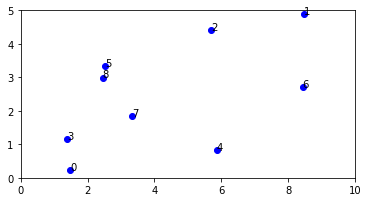

In [217]:
#np.random.seed(0)

board = CityBoard()
board.generateCities(9)
board.plot()

optimal:   2.07282185555s
optimal:   20.11384332292258 [len]
2-Approx:  0.00164103507996s
2-Approx:  23.098041150786315 [len]


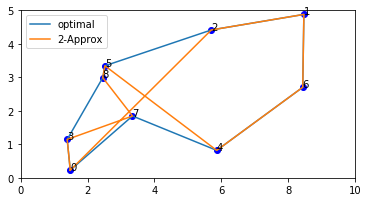

In [218]:
comparing_solutions = []

route, cost, needed_time = OptimalSolver.solve(board)
print('optimal:   ' + str(needed_time) + 's')
print('optimal:   ' + str(cost) + ' [len]')
comparing_solutions.append( (route, cost, 'optimal') )

route, cost, needed_time = MSTSolver.solve(board)
print('2-Approx:  ' + str(needed_time) + 's')
print('2-Approx:  ' + str(cost) + ' [len]')
comparing_solutions.append( (route, cost, '2-Approx') )

board.plot(comparing_solutions)

## Try for different city sizes

('iteration', 2)
('iteration', 3)
('iteration', 4)
('iteration', 5)
('iteration', 6)
('iteration', 7)
('iteration', 8)
('iteration', 9)
('iteration', 10)


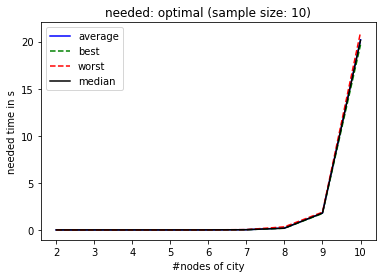

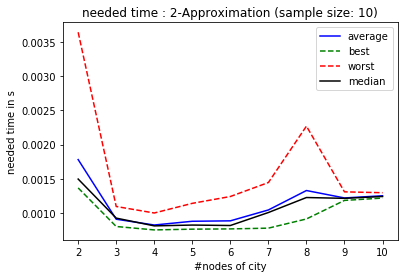

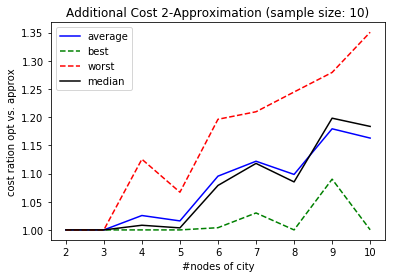

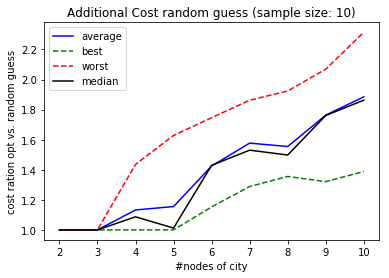

In [221]:
optimal_times = []
two_approx_times = []
cost_ratio_2approx = []
cost_ratio_guesses = []
samples = 10
smalles_city_size = 2
largest_city_size = 10

city_sizes = range(smalles_city_size, largest_city_size+1)

for i in city_sizes:
    current_time_optimal = [] 
    current_time_2approx = []
    cost_ratio = []
    guess_cost_ratio = []
    for sample_nr in range(samples):
        board.generateCities(i)
        _, cost_opt, optimal_needed_time        = OptimalSolver.solve(board)
        _, cost_twoapprx, twoapprox_needed_time = MSTSolver.solve(board)
        _, cost_guess, _                        = RandomSolver.solve(board)
        current_time_optimal.append(optimal_needed_time)
        current_time_2approx.append(twoapprox_needed_time)
        #print(cost_opt, cost_twoapprx)
        cost_ratio.append(cost_twoapprx / cost_opt )
        guess_cost_ratio.append(cost_guess / cost_opt )
        #print(cost_twoapprx / cost_opt)
        
    optimal_times.append(current_time_optimal)
    two_approx_times.append(current_time_2approx)
    cost_ratio_2approx.append(cost_ratio)
    cost_ratio_guesses.append(guess_cost_ratio)

    
    print('iteration' ,i)

    
plots = [(optimal_times,     'needed: optimal',                 'needed time in s'), 
         (two_approx_times,  'needed time : 2-Approximation',   'needed time in s'), 
         (cost_ratio_2approx,'Additional Cost 2-Approximation', 'cost ration opt vs. approx'), 
         (cost_ratio_guesses,'Additional Cost random guess',    'cost ration opt vs. random guess')]

for (plot_type, description, ylabel) in plots:
    plt.plot(city_sizes,[np.average(problemsize) for problemsize in plot_type], 'b',    label="average")
    plt.plot(city_sizes,[np.min(problemsize)     for problemsize in plot_type], 'g--',  label="best")
    plt.plot(city_sizes,[np.max(problemsize)     for problemsize in plot_type], 'r--',  label="worst")
    plt.plot(city_sizes,[np.median(problemsize)  for problemsize in plot_type], 'black',label="median")

    plt.title(description + ' (sample size: ' + str(samples) + ')')
    plt.xlabel('#nodes of city')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
